# Actividad Naive Bayes 

- Integrantes: 
  - Francisco Couttolenc A01754959
  - Jorge Emiliano Pomar A01709338

## Parte 1 Penguins


(20 pts) Copia el siguiente notebook Gaussian NB. y modifícalo para probar su funcionamiento con el dataset penguins. Reporta su accuracy para ambos conjuntos de entrenamiento y prueba.


In [21]:
import pandas as pd
import numpy as np

df = pd.read_csv("penguins.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [ ]:
df.drop("sex", axis=1, inplace=True)

In [ ]:
df.drop("island", axis=1, inplace=True)

<Axes: >

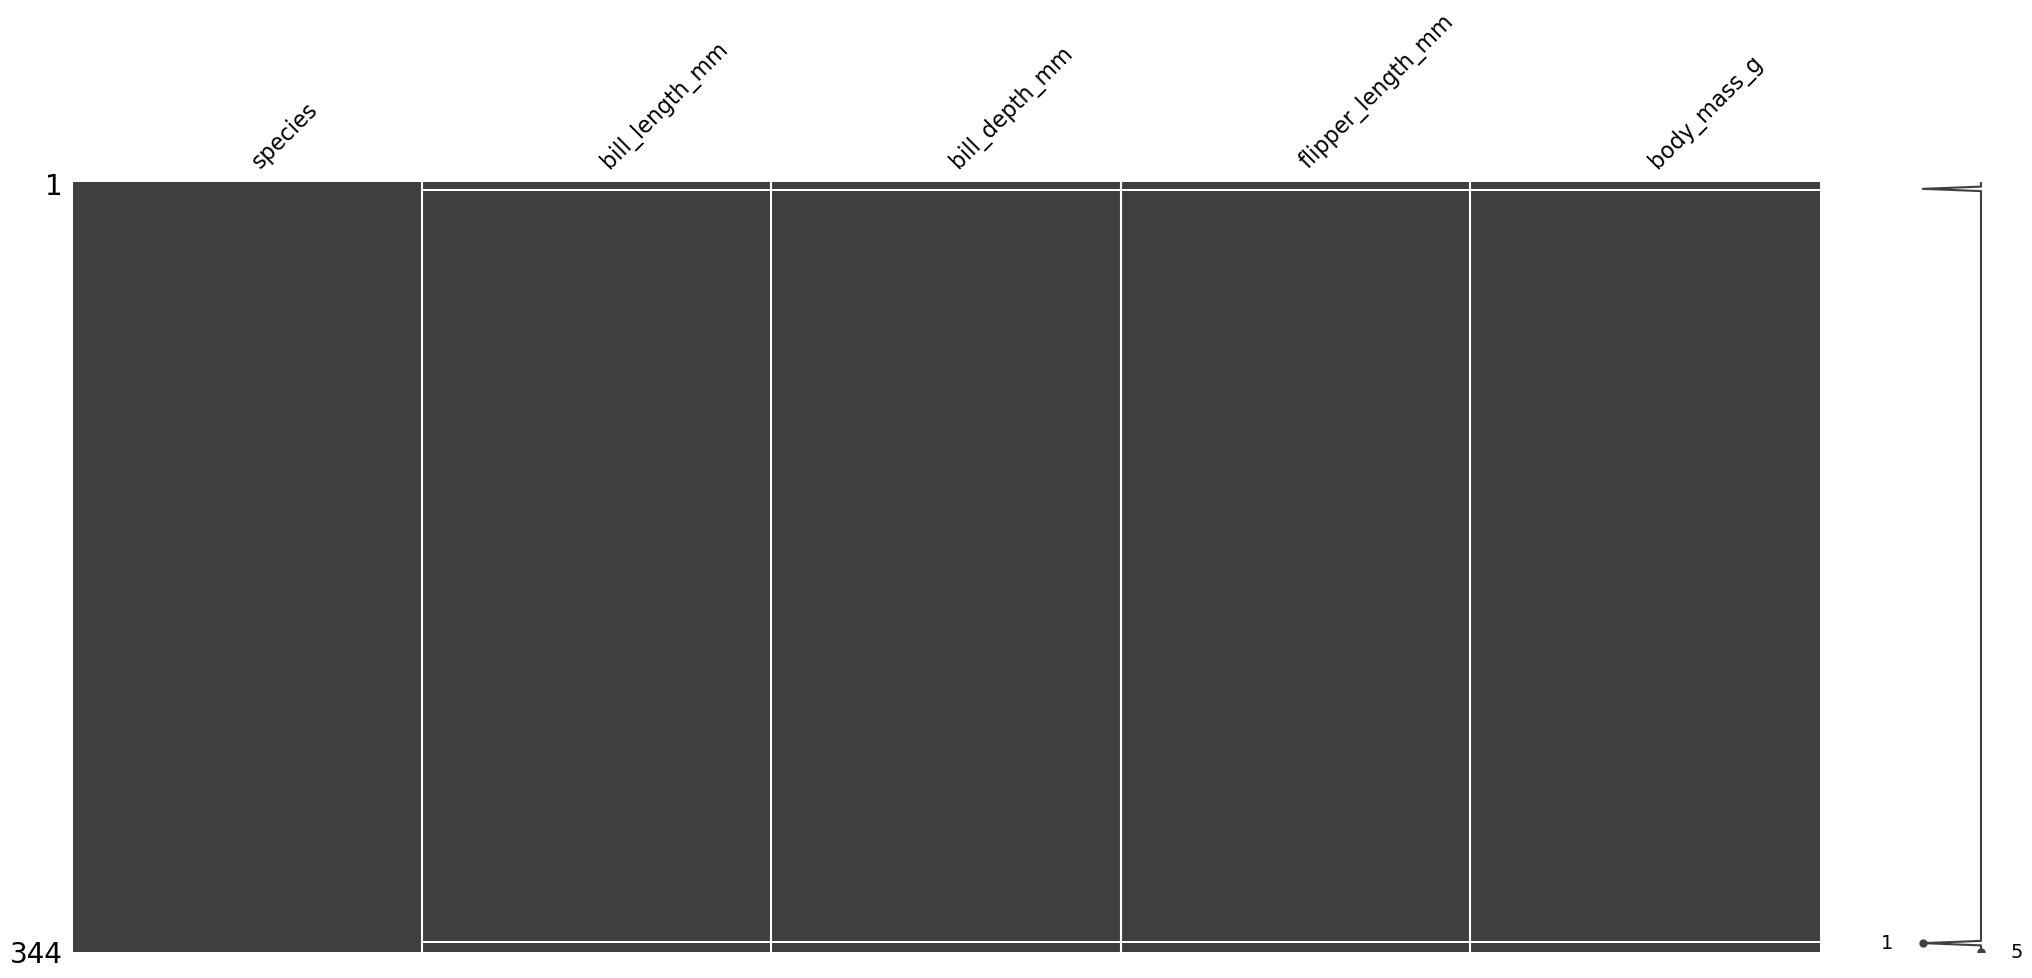

In [ ]:
import missingno as msgno

msgno.matrix(df)

In [25]:
df.dropna(axis=0, inplace=True)

<Axes: >

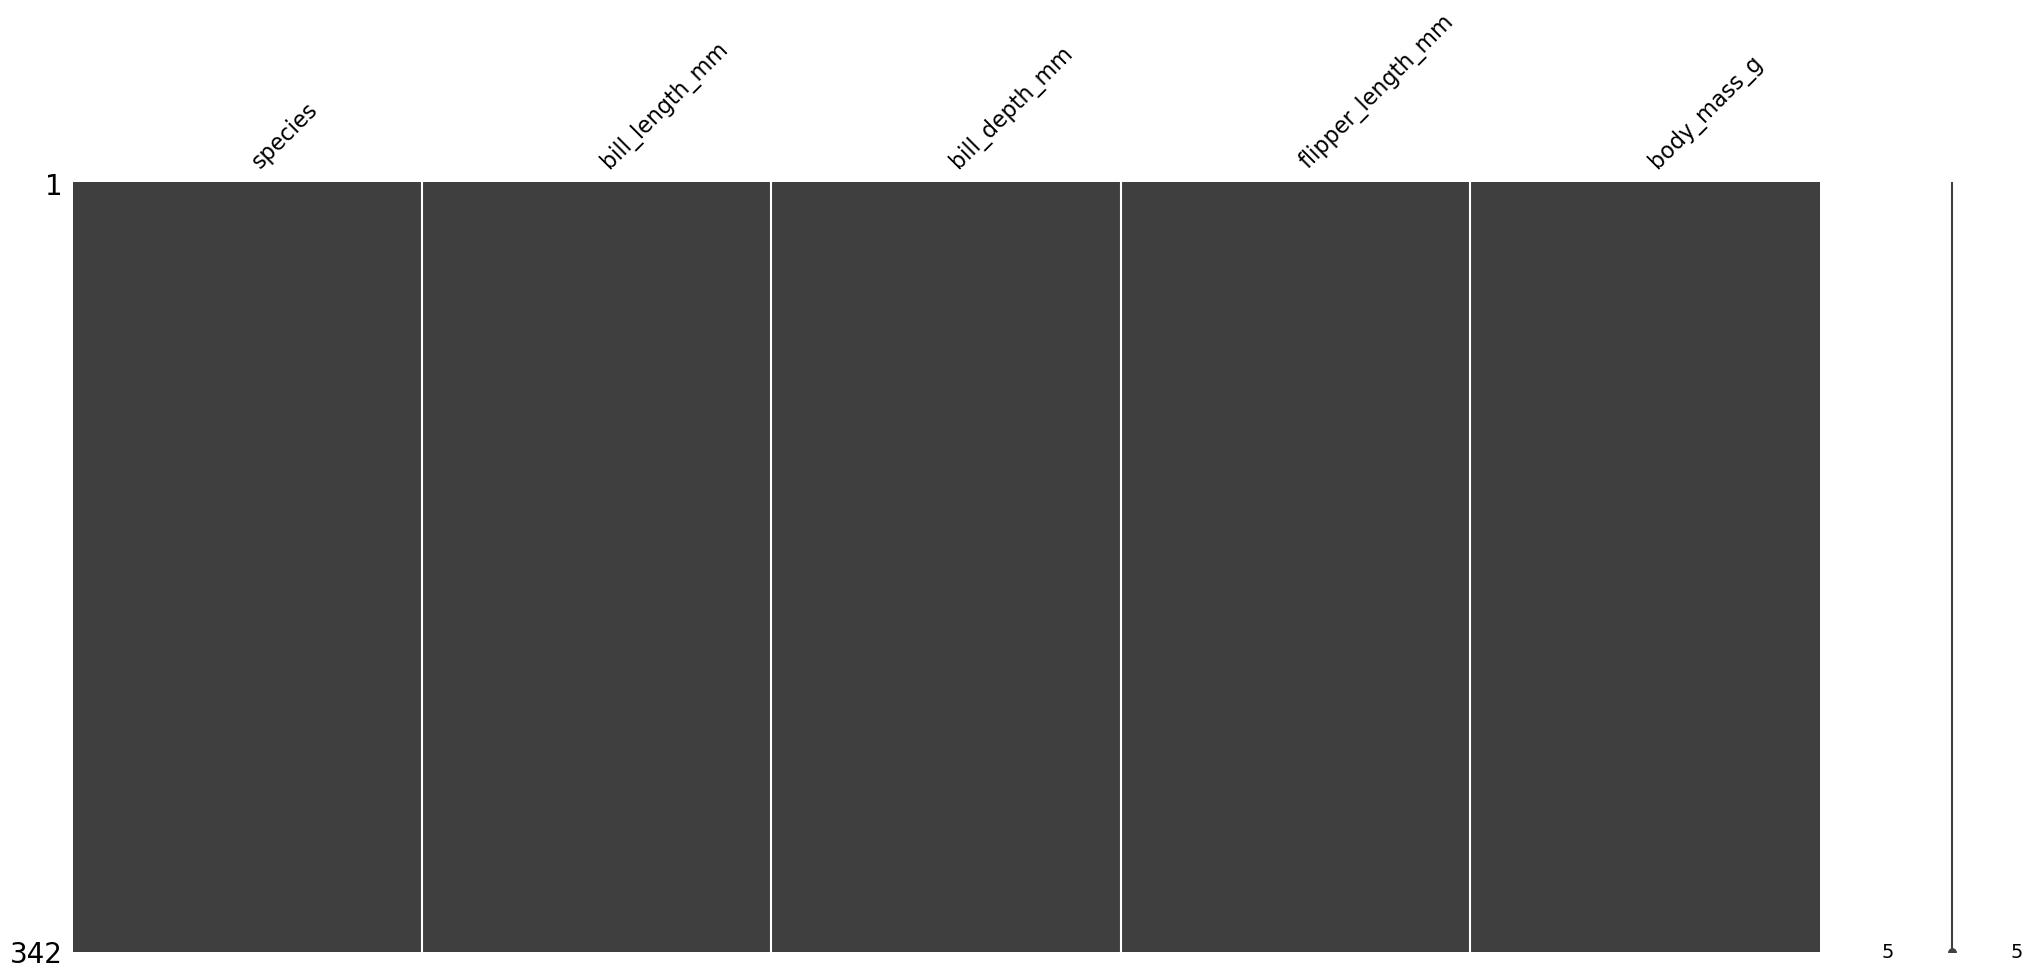

In [26]:
msgno.matrix(df)

In [ ]:
train = df.sample(frac=0.7, random_state=1)
test = df.drop(train.index)

y_train = train["species"]
x_train = train.drop("species", axis=1)

y_test = test["species"]
x_test = test.drop("species", axis=1)
print(
    "Dimensiones de datos de prueba",
    x_test.shape,
    "\nDimensiones de datos de entrenamiento",
    x_train.shape,
)

Dimensiones de datos de prueba (103, 4) 
Dimensiones de datos de entrenamiento (239, 4)


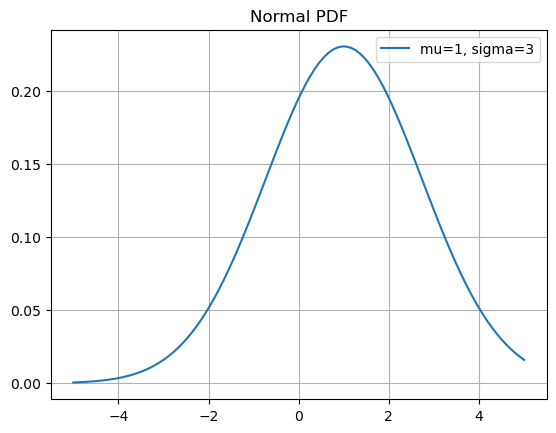

In [ ]:
import matplotlib.pyplot as plt


def normalpdf(n, mu=0, sigma=1):
    # Funcion para estimar PDF (Probability Density Function) dado que hay una distribucion Normal(mu, var) evaluado con x
    sd = np.sqrt(sigma)
    pdf = (np.e ** (-0.5 * ((n - mu) / sd) ** 2)) / (sd * np.sqrt(2 * np.pi))
    return pdf


# Define the parameters of the Gaussian function
mu = 1  # mean
sigma = 3  # standard deviation

xs = np.linspace(-5, 5, 100)
ys = normalpdf(xs, mu, sigma)

# Generate plot
plt.title("Normal PDF")
plt.plot(xs, ys, label="mu=" + str(mu) + ", sigma=" + str(sigma))
plt.legend()  # incluir label
plt.grid(True)
plt.show()

In [ ]:
# Exclude non-numeric columns before applying aggregation functions
numeric_columns = train.select_dtypes(include=[np.number]).columns

means = train.groupby(["species"])[
    numeric_columns
].mean()  # Estimacion de la media de cada clase, por característica
var = train.groupby(["species"])[
    numeric_columns
].var()  # Estimacion de la varianza de cada clase, por característica
prior = train["species"].value_counts() / len(
    train
)  # Estimacion probabilidades a priori P(C)
clases = np.unique(train["species"].tolist())  # Todas las clases posibles

print("Estimacion de la media de cada clase, por característica:\n", means)
print("\nEstimacion de la varianza de cada clase, por característica\n", var)
print("\nEstimacion probabilidades a priori\n", prior)

Estimacion de la media de cada clase, por característica:
            bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
species                                                                 
Adelie          38.802941      18.445098         190.411765  3731.372549
Chinstrap       48.880392      18.386275         195.450980  3716.176471
Gentoo          47.568605      15.073256         217.325581  5137.209302

Estimacion de la varianza de cada clase, por característica
            bill_length_mm  bill_depth_mm  flipper_length_mm    body_mass_g
species                                                                   
Adelie           7.674348       1.606659          43.690157  228015.919239
Chinstrap       11.611608       1.421208          60.772549  164145.588235
Gentoo           8.393709       0.929041          40.339808  261290.355677

Estimacion probabilidades a priori
 species
Adelie       0.426778
Gentoo       0.359833
Chinstrap    0.213389
Name: count, dtype: float64


In [ ]:
def predict(X):
    predictions = []

    for i in X.index:  # Loop through each instance

        ClassLikelihood = []
        instance = X.loc[i]

        for cls in clases:  # Loop through each class

            FeatureLikelihoods = []
            FeatureLikelihoods.append(
                np.log(prior[cls])
            )  # Append log prior of class 'cls'

            for col in x_train.columns:  # Loop through each feature

                data = instance[col]

                # Handle missing values
                if pd.isna(data):
                    Likelihood = (
                        1e-10  # Assign a very small likelihood for missing values
                    )
                else:
                    mean = means[col].loc[
                        cls
                    ]  # Find the mean of column 'col' that are in class 'cls'
                    variance = var[col].loc[
                        cls
                    ]  # Find the variance of column 'col' that are in class 'cls'

                    # Handle zero variance
                    if variance == 0:
                        variance = 1e-10  # Assign a very small variance to avoid division by zero

                    Likelihood = normalpdf(data, mean, variance)

                # Handle zero likelihood
                if Likelihood != 0:
                    Likelihood = np.log(
                        Likelihood
                    )  # Find the log-likelihood evaluated at x
                else:
                    Likelihood = (
                        -1e10
                    )  # Assign a very small log-likelihood for zero likelihood

                FeatureLikelihoods.append(Likelihood)

            TotalLikelihood = sum(FeatureLikelihoods)  # Calculate posterior
            ClassLikelihood.append(TotalLikelihood)

        MaxIndex = ClassLikelihood.index(
            max(ClassLikelihood)
        )  # Find largest posterior position
        prediction = clases[MaxIndex]
        predictions.append(prediction)

    return predictions

In [ ]:
PredictTrain = predict(x_train)
PredictTest = predict(x_test)

# Despliega su precisión
print(
    "Training set Accuracy: ",
    round(100 * sum(PredictTrain == y_train) / len(y_train), 3),
    "%",
)
print(
    "Testing set Accuracy: ",
    round(100 * sum(PredictTest == y_test) / len(y_test), 3),
    "%",
)

Training set Accuracy:  97.071 %
Testing set Accuracy:  98.058 %


## Parte 2

Carga a un dataframe estos datos (respuestasLinks to an external site.) donde se tienen las respuestas a una encuesta. Tomando como variable objetivo la columna "Desenlace" y al resto (menos "marca temporal") como características analicen y respondan:
¿Se puede utilizar este algoritmo (Gaussian Naive Bayes) para entrenar un modelo clasificador?
Si se tiene que modificar entonces: ¿porqué se tiene que modificar el código/algoritmo?
¿Qué cambios se tienen que realizar?


In [ ]:
registros_df = pd.read_excel("Registro (Respuestas).xlsx")
registros_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Marca temporal           34 non-null     datetime64[ns]
 1   Atención                 34 non-null     object        
 2   Higiene                  34 non-null     object        
 3   Amabilidad               34 non-null     object        
 4   Atractiva(o)             34 non-null     object        
 5   Buen humor               34 non-null     object        
 6   Situación sentimental    34 non-null     object        
 7   Mentalidad Conservadora  34 non-null     object        
 8   Desenlace                34 non-null     object        
dtypes: datetime64[ns](1), object(8)
memory usage: 2.5+ KB


In [33]:
registros_df.head(5)

,Marca temporal,Atención,Higiene,Amabilidad,Atractiva(o),Buen humor,Situación sentimental,Mentalidad Conservadora,Desenlace
0,2024-04-15 16:48:35.256,SI,SI,SI,SI,NO,NO,NO,Éxito
1,2024-04-15 16:48:38.069,SI,SI,SI,SI,SI,NO,NO,Fallo
2,2024-04-15 16:48:46.723,SI,SI,SI,SI,SI,NO,NO,Éxito
3,2024-04-15 16:48:49.049,NO,SI,SI,SI,SI,NO,SI,Éxito
4,2024-04-15 16:49:12.096,SI,SI,SI,SI,SI,NO,NO,Éxito


<Axes: >

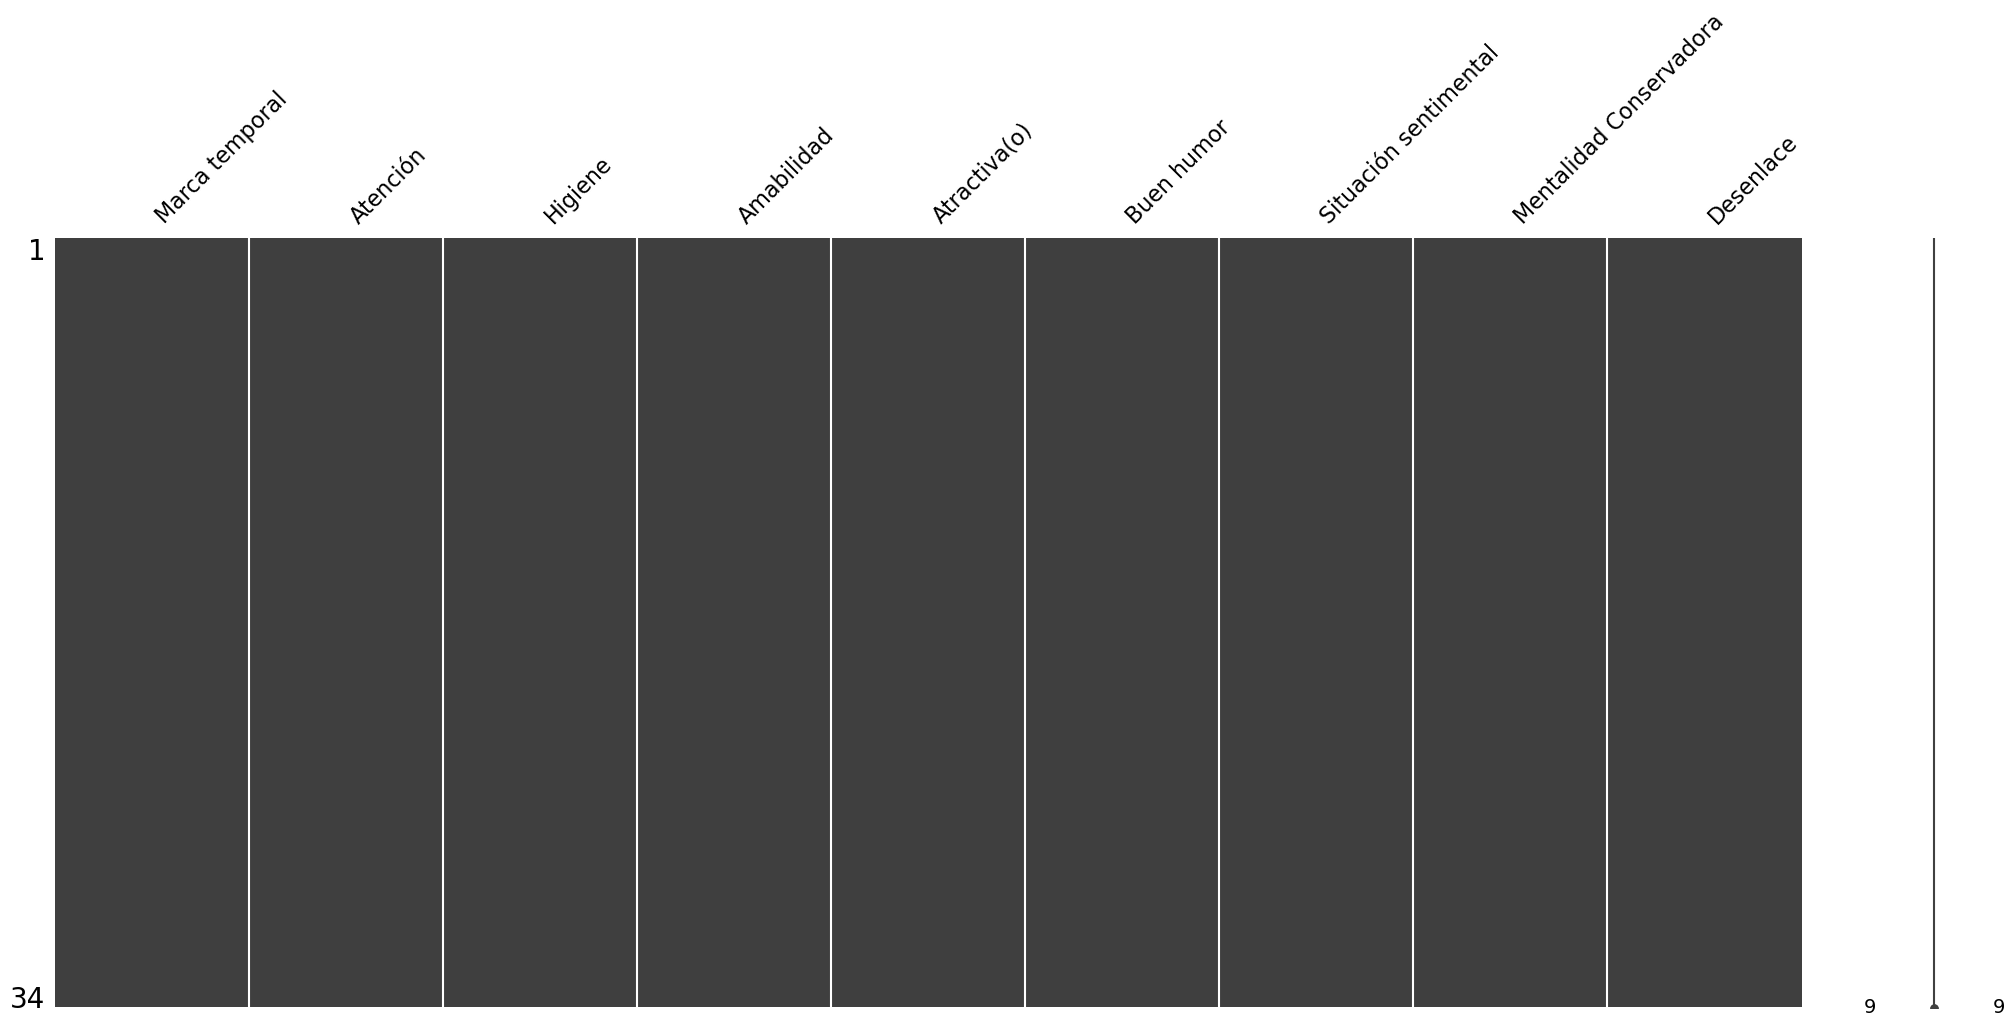

In [34]:
msgno.matrix(registros_df)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Crear una copia del dataframe
df_encoded = registros_df.copy()

# Codificar todas las columnas categóricas menos la de "Desenlace"
label_encoders = {}
for col in df_encoded.columns:
    if col not in ["Marca temporal", "Desenlace"]:
        if df_encoded[col].dtype == "object":
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col])
            label_encoders[col] = le

In [36]:
le_desenlace = LabelEncoder()
df_encoded["Desenlace"] = le_desenlace.fit_transform(df_encoded["Desenlace"])

In [ ]:
train = df_encoded.sample(frac=0.7, random_state=1)
test = df_encoded.drop(train.index)

y_train_registros = train["Desenlace"]
x_train_registros = train.drop("Desenlace", axis=1)

y_test_registros = test["Desenlace"]
x_test_registros = test.drop("Desenlace", axis=1)
print(
    "Dimensiones de datos de prueba",
    x_test_registros.shape,
    "\nDimensiones de datos de entrenamiento",
    x_train_registros.shape,
)

Dimensiones de datos de prueba (10, 8) 
Dimensiones de datos de entrenamiento (24, 8)


In [ ]:
# Exclude non-numeric columns before applying aggregation functions
numeric_columns = train.select_dtypes(include=[np.number]).columns

means = train.groupby(["Desenlace"])[
    numeric_columns
].mean()  # Estimacion de la media de cada clase, por característica
var = train.groupby(["Desenlace"])[
    numeric_columns
].var()  # Estimacion de la varianza de cada clase, por característica
prior = train["Desenlace"].value_counts() / len(
    train
)  # Estimacion probabilidades a priori P(C)
clases = np.unique(train["Desenlace"].tolist())  # Todas las clases posibles

print("Estimacion de la media de cada clase, por característica:\n", means)
print("\nEstimacion de la varianza de cada clase, por característica\n", var)
print("\nEstimacion probabilidades a priori\n", prior)

Estimacion de la media de cada clase, por característica:
            Atención   Higiene  Amabilidad  Atractiva(o)  Buen humor  \
Desenlace                                                             
0          0.800000  1.000000    0.700000      0.700000         0.7   
1          0.785714  0.928571    0.928571      0.857143         1.0   

           Situación sentimental  Mentalidad Conservadora  Desenlace  
Desenlace                                                             
0                       0.300000                 0.400000        0.0  
1                       0.071429                 0.285714        1.0  

Estimacion de la varianza de cada clase, por característica
            Atención   Higiene  Amabilidad  Atractiva(o)  Buen humor  \
Desenlace                                                             
0          0.177778  0.000000    0.233333      0.233333    0.233333   
1          0.181319  0.071429    0.071429      0.131868    0.000000   

           Situación sent

In [ ]:
def predict_registros(X):
    predictions = []

    for i in X.index:  # Loop through each instance

        ClassLikelihood = []
        instance = X.loc[i]

        for cls in clases:  # Loop through each class

            FeatureLikelihoods = []
            FeatureLikelihoods.append(
                np.log(prior[cls])
            )  # Append log prior of class 'cls'

            for col in x_train_registros.columns:  # Loop through each feature

                data = instance[col]

                # Handle missing values
                if pd.isna(data):
                    Likelihood = (
                        1e-10  # Assign a very small likelihood for missing values
                    )
                else:
                    mean = means[col].loc[
                        cls
                    ]  # Find the mean of column 'col' that are in class 'cls'
                    variance = var[col].loc[
                        cls
                    ]  # Find the variance of column 'col' that are in class 'cls'

                    # Handle zero variance
                    if variance == 0:
                        variance = 1e-10  # Assign a very small variance to avoid division by zero

                    Likelihood = normalpdf(data, mean, variance)

                # Handle zero likelihood
                if Likelihood != 0:
                    Likelihood = np.log(
                        Likelihood
                    )  # Find the log-likelihood evaluated at x
                else:
                    Likelihood = (
                        -1e10
                    )  # Assign a very small log-likelihood for zero likelihood

                FeatureLikelihoods.append(Likelihood)

            TotalLikelihood = sum(FeatureLikelihoods)  # Calculate posterior
            ClassLikelihood.append(TotalLikelihood)

        MaxIndex = ClassLikelihood.index(
            max(ClassLikelihood)
        )  # Find largest posterior position
        prediction = clases[MaxIndex]
        predictions.append(prediction)

    return predictions

In [ ]:
# Quitamos marca temporal si tiene datos que no ayudan para el train y test
x_train_registros = x_train_registros.drop(columns=["Marca temporal"], errors="ignore")
x_test_registros = x_test_registros.drop(columns=["Marca temporal"], errors="ignore")

PredictTrain = predict_registros(x_train_registros)
PredictTest = predict_registros(x_test_registros)

# Despliega su precisión
print(
    "Training set Accuracy: ",
    round(100 * sum(PredictTrain == y_train_registros) / len(y_train_registros), 3),
    "%",
)
print(
    "Testing set Accuracy: ",
    round(100 * sum(PredictTest == y_test_registros) / len(y_test_registros), 3),
    "%",
)

Training set Accuracy:  75.0 %
Testing set Accuracy:  50.0 %


## Usando solo Sklearn (para comparar)


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gnb = GaussianNB()
gnb.fit(x_train_registros, y_train_registros)
sklearn_preds = gnb.predict(x_test_registros)

custom_preds = predict_registros(x_test_registros)

print("Accuracy sklearn:", accuracy_score(y_test_registros, sklearn_preds))
print("Accuracy predict registros:", accuracy_score(y_test_registros, custom_preds))

Accuracy sklearn: 0.5
Accuracy custom: 0.5


### Conclusión

¿Se puede utilizar este algoritmo (Gaussian Naive Bayes) para entrenar un modelo clasificador?  
**Respuesta:**  
Sí lo puedes usar para entrenar un modelo clasificador, siempre y cuando los datos sean numéricos y las distribuciones de las variables sigan una distribución normal. En este caso de penguins y registros, no se puede utilizar directamente el algoritmo de Gaussian Naive Bayes, ya que las características no son numéricas y hay valores categóricos. Es por eso que tuvimos que modificar algunas columnas.

Si se tiene que modificar entonces:  
¿porqué se tiene que modificar el código/algoritmo?  
**Respuesta:**  
Porque Naive Bayes asume que las características son independientes y siguen una distribución normal. En ambos casos no hay una distribución normal y hay columnas con datos no numéricos. Por lo tanto, el algoritmo no puede funcionar correctamente sin realizar modificaciones en los datos.

¿Qué cambios se tienen que realizar?  
**Respuesta:**

1. Lo mejor sería convertir los datos de texto a numéricos usando un codificador. Pero este no es el caso ya que no hay columnas categóricas como para usar un codificador.
2. Si hay columnas con datos de texto que no se pueden convertir a numéricos, entonces se deben eliminar esas columnas.
3. Por último, si hay columnas con datos nulos, hay que eliminarlas o rellenarlas con un valor numérico. En este caso, eliminamos todas las entradas nulas.

Cabe resaltar que la implementación usnado solo sklearn tampoco funcionó con resultados que notoriamente superaran a los nuestros. Principlamente porque se utiliza los mismos datos de train y test que nosotros. Esto porque como podíamos anticipar, el modelo necesita datos con distribución normal numéricos. Por lo tanto, el modelo de sklearn tampoco funcionó correctamente. Lo que demuestra que en realidad el problema son la forma en la que se tienen que clasificar los datos y no el algoritmo en sí.


### Actividad 3
*(50 pts) De acuerdo a sus respuestas modifica el notebook compartido para incluir tu implementación de tu propio clasificador y reporten sus resultados (accuracy).*

El siguiente código fue generado por Copilot de Github. Muestra el clasificador Niave Bayes para el dataset de los Registros de la encuesta. Esta implementación asumió que los datos eran numéricos y categóricos. Y que tenían una distribución normal. Por lo tanto, la implementación falló en la primer corrida. Ya en una segunda petición a Copilot, se generó el siguiente código, en el que puso una función para eliminar las columnas categóricas y nulas. Y luego se generó el clasificador. 
Los resultados fueron los siguientes:


`Training set Accuracy (Custom Classifier) with new data: 62.50%`

`Testing set Accuracy (Custom Classifier) with new data: 70.00%`


Estos resultados son mejores en cuanro al entrenamiento. Y tiene un buen balance entre el entrenamiento y la prueba. La diferencia entre esta nueva implementación de la IA y la anterior es que si se utilizó un encoder que específicamente ayudó a la columna de "Desenlace". En la primera implementación, asumimos que la columna de "Desenlace" no tenía errores.

In [46]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Importar nuevamente el archivo
new_registros_df = pd.read_excel("Registro (Respuestas).xlsx")

# Codificar las columnas categóricas menos "Desenlace"
new_df_encoded = new_registros_df.copy()
for col in new_df_encoded.columns:
    if col not in ["Marca temporal", "Desenlace"]:
        if new_df_encoded[col].dtype == "object":
            le = LabelEncoder()
            new_df_encoded[col] = le.fit_transform(new_df_encoded[col])

# Codificar la columna "Desenlace"
le_desenlace = LabelEncoder()
new_df_encoded["Desenlace"] = le_desenlace.fit_transform(new_df_encoded["Desenlace"])

# Excluir la columna "Marca temporal" antes de dividir los datos
new_df_encoded.drop(columns=["Marca temporal"], inplace=True, errors="ignore")

# Dividir en datos de entrenamiento y prueba
new_train = new_df_encoded.sample(frac=0.7, random_state=42)
new_test = new_df_encoded.drop(new_train.index)

new_y_train = new_train["Desenlace"]
new_x_train = new_train.drop("Desenlace", axis=1)

new_y_test = new_test["Desenlace"]
new_x_test = new_test.drop("Desenlace", axis=1)

# Definir el clasificador personalizado como GaussianNB
custom_clf = GaussianNB()

# Entrenar el clasificador personalizado con los nuevos datos
custom_clf.fit(new_x_train, new_y_train)

# Realizar predicciones con los nuevos datos
new_custom_train_preds = custom_clf.predict(new_x_train)
new_custom_test_preds = custom_clf.predict(new_x_test)

# Calcular la precisión con los nuevos datos
new_train_accuracy = accuracy_score(new_y_train, new_custom_train_preds)
new_test_accuracy = accuracy_score(new_y_test, new_custom_test_preds)

print(f"Training set Accuracy (Custom Classifier) with new data: {new_train_accuracy * 100:.2f}%")
print(f"Testing set Accuracy (Custom Classifier) with new data: {new_test_accuracy * 100:.2f}%")


Training set Accuracy (Custom Classifier) with new data: 62.50%
Testing set Accuracy (Custom Classifier) with new data: 70.00%
